# SARIMA Model

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Step 1: Prepare NO2 time series

In [19]:
import sys, os
sys.path.append(os.path.abspath("../src"))

import data_preprocessing
from importlib import reload
reload(data_preprocessing)

df = data_preprocessing.load_and_engineer()
print(df.shape, df.columns[:5])


(803, 32) Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)'], dtype='object')


In [20]:
# Chronological split (70% train, 30% test)
ts = df["NO2(GT)"]  # directly grab the target series
split_idx = int(len(ts) * 0.7)
train, test = ts.iloc[:split_idx], ts.iloc[split_idx:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (562,)
Test shape: (241,)


## Step 2: Fit SARIMA

In [21]:

# -------------------------------
# (p,d,q) x (P,D,Q,s)
# - p/q from PACF/ACF (Phase 2 showed daily lags ~24h)
# - s = 24 (daily cycle for hourly data)
# -------------------------------

# This is a starting point; can tune later
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 24)

sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())

/Users/papijorge/Downloads/College/FourthYear/OperationalizingAI/Real-Time Air Quality Prediction with Apache Kafka/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/papijorge/Downloads/College/FourthYear/OperationalizingAI/Real-Time Air Quality Prediction with Apache Kafka/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                              NO2(GT)   No. Observations:                  562
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               -2162.989
Date:                              Tue, 23 Sep 2025   AIC                           4339.978
Time:                                      22:15:53   BIC                           4369.619
Sample:                                           0   HQIC                          4351.599
                                              - 562                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3626      0.088     15.439      0.000       1.190       1.536
ar.L2         -0.57

## Step 3: Forecast on Test Set

In [23]:
# Forecast using positional indices
y_pred_sarima = sarima_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
y_pred_sarima.index = test.index  # align with datetime

# Metrics
mae_sarima = mean_absolute_error(test, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, y_pred_sarima))

print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

SARIMA MAE: 40.39
SARIMA RMSE: 48.65


/Users/papijorge/Downloads/College/FourthYear/OperationalizingAI/Real-Time Air Quality Prediction with Apache Kafka/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/papijorge/Downloads/College/FourthYear/OperationalizingAI/Real-Time Air Quality Prediction with Apache Kafka/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Step 4: Compare with Baseline

In [24]:
y_naive = test.shift(1).bfill()
mae_naive = mean_absolute_error(test, y_naive)
rmse_naive = np.sqrt(mean_squared_error(test, y_naive))

print(f"Baseline MAE: {mae_naive:.2f}")
print(f"Baseline RMSE: {rmse_naive:.2f}")

Baseline MAE: 13.00
Baseline RMSE: 16.79


## Step 5: Plot Forecast vs Actual

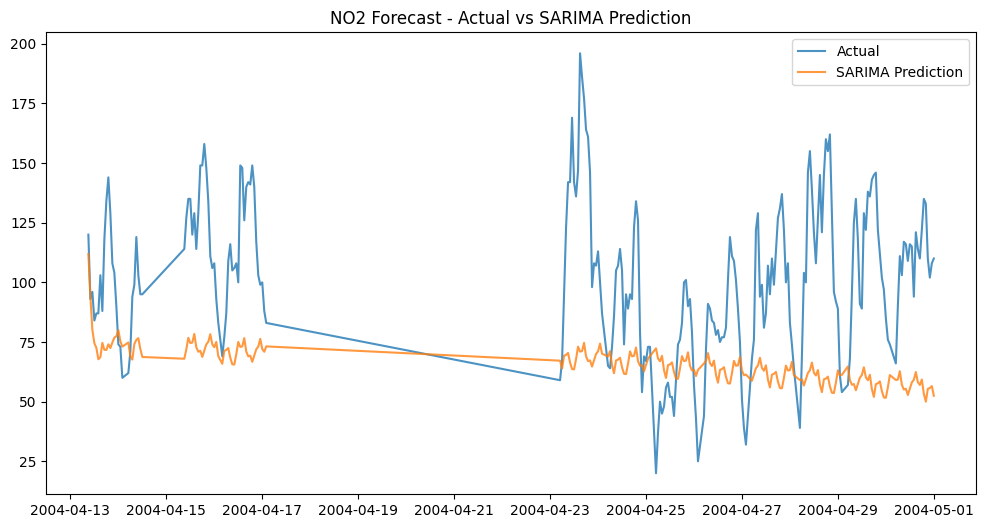

In [25]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual", alpha=0.8)
plt.plot(test.index, y_pred_sarima, label="SARIMA Prediction", alpha=0.8)
plt.legend()
plt.title("NO2 Forecast - Actual vs SARIMA Prediction")
plt.show()


In [26]:
preds_sarima = pd.DataFrame({
    "y_test": test,
    "y_pred_sarima": y_pred_sarima
})
preds_sarima.to_csv("../results/sarima_predictions.csv")
